## Fine Tune mentalBert or Robert large for classification

Fine tune to classify stress or no stress using messages from
Dreaddit: A Reddit Dataset for Stress Analysis in Social Media.
See: https://aclanthology.org/D19-6213

In [ ]:
!pip install transformers
!pip install datasets # extension of the transformers library

In [ ]:
import pandas as pd
import time
########## test
import torch
import numpy as np
from torch.nn.functional import softmax

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

##########
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    TextClassificationPipeline)

In [ ]:
# Set start time for training
start_time = time.time()

#### Logon to HuggingFace

In [ ]:
### the safer way
#from huggingface_hub import notebook_login
#notebook_login()

### alternative
from huggingface_hub import login
login('') # put your User Access Tokens here

#### Load messages, dropping nulls and sorting on date created.


In [ ]:
# URL of the raw CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/SocialHealthAI/SDOH-Models/refs/heads/main/LLM%20Classification/dreaddit-train.csv"

# Load the CSV file into a DataFrame
train_df = pd.read_csv(csv_url)
train_df = train_df.head(9600)             # shorten training time
#dreadit_text_df = dreadit_df[['text']]

# URL of the raw CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/SocialHealthAI/SDOH-Models/refs/heads/main/LLM%20Classification/dreaddit-test.csv"

# Load the CSV file into a DataFrame
test_df = pd.read_csv(csv_url)
test_df = test_df.head(600)             # shorten training time
#dreadit_text_df = dreadit_df[['text']]

# drop null text
train_df.dropna(subset=['text'], inplace=True)
test_df.dropna(subset=['text'], inplace=True)


In [ ]:
label_names = ['0', '1']

#### Split test data into test and validation data

In [ ]:
# Calculate the split index
split_index = len(test_df) // 2

# Split the DataFrame
validation_df = test_df.iloc[:split_index]
test_df = test_df.iloc[split_index:]


#### Set up Tokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
#tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large")
tokenizer

BertTokenizerFast(name_or_path='mental/mental-bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

#### Encode training and validation data

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(validation_df['text'].values.tolist())
#test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

#### Create datasets and dataloaders

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(validation_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([2838]), torch.Size([300]), torch.Size([300]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

#test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
#test_sampler = SequentialSampler(test_dataset)
#test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

#### Load Model using HuggingFace

In [ ]:
from transformers import BertForSequenceClassification
N_labels = len(train_df.label.unique())

model = AutoModelForSequenceClassification.from_pretrained(
    "mental/mental-bert-base-uncased",
    #"FacebookAI/xlm-roberta-large",
    problem_type="single_label_classification",                                # added, why? its binary
    num_labels=N_labels,  # Number of output labels
    device_map={"": 0}  # Optional dictionary specifying device mapping (single GPU with index 0 here)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Model on GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

#### Fine TuningHyperparameters

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3  #training and validation loss intersect at 2
LEARNING_RATE = 5e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

#### Fine Tuning

In [ ]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(validation_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

178/178 train loss: 0.5169153949350453 
19/19 val loss: 0.4585408999731666 
Epoch:  2


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

178/178 train loss: 0.3736761255043276 
19/19 val loss: 0.4507079900879609 
Epoch:  3


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

178/178 train loss: 0.33037223373905994 
19/19 val loss: 0.4495009630918503 


In [ ]:
# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Time required by training: {elapsed_time:.4f} seconds")

Time required by training: 109.3433 seconds


#### Plot training and validation loss

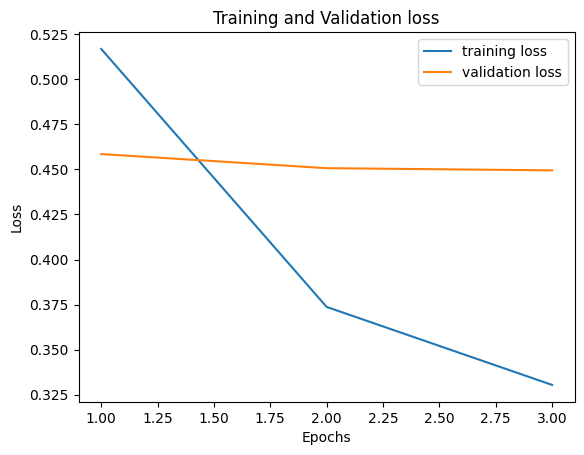

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

#### Classification metrics

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, validation_df['label'].to_numpy(), target_names=label_names))

classifiation report
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       128
           1       0.87      0.78      0.82       172

    accuracy                           0.81       300
   macro avg       0.80      0.81      0.80       300
weighted avg       0.81      0.81      0.81       300



#### Save model and tokenizer

In [ ]:
# Define the directory to save the model and tokenizer
save_directory = "./fine_tuned_bert_model"

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./fine_tuned_bert_model


### Starting time for Inference

In [ ]:
# Set start time for Inference
start_time = time.time()

### Load model and tokenizer

In [ ]:
# Reload the model and tokenizer
reloaded_model = AutoModelForSequenceClassification.from_pretrained(save_directory)
reloaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)

### Encode test data

In [ ]:
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())  #uses training tokenizer, but thats OK
test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

#### Inference
Create list of predicted class and probability of predicted class.

The probabilities reflect the model’s confidence in each class, but since transformer models are highly non-linear and contextual, these probabilities are influenced by complex attention-based representations rather than just a simple linear decision boundary as in logistic regression.

In [ ]:
reloaded_model.eval()
test_pred = []
test_probs = []  # Store probability distributions
test_loss = 0

with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

        loss = output.loss
        test_loss += loss.item()

        logits = output.logits.cpu().detach().numpy()
        probs = softmax(torch.tensor(logits), dim=-1).numpy()  # Apply softmax

        test_pred.append(np.argmax(logits, axis=-1))
        test_probs.append(probs)

test_pred = np.concatenate(test_pred)
test_probs = np.concatenate(test_probs)  # Shape: (num_samples, num_classes)



0it [00:00, ?it/s]

In [ ]:
# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Time required by inference: {elapsed_time:.4f} seconds")

Time required by inference: 1.2227 seconds


#### Test Classification Metrics

In [ ]:
print('classifiation report')
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       123
           1       0.90      0.79      0.84       177

    accuracy                           0.82       300
   macro avg       0.82      0.83      0.82       300
weighted avg       0.83      0.82      0.82       300



#### AUC

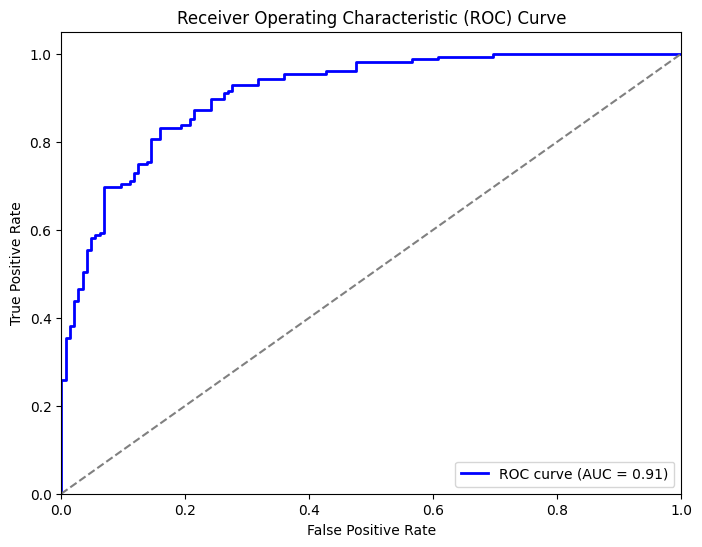

In [ ]:
# Convert labels to NumPy array if not already
true_labels = test_df['label'].to_numpy()

# If binary classification, extract probability of positive class (class 1)
if test_probs.shape[1] == 2:
    positive_probs = test_probs[:, 1]  # Probability of class 1
else:
    raise ValueError("ROC is typically used for binary classification. For multi-class, consider One-vs-Rest.")

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, positive_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Example Inferences

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']==test_df['pred']].shape)
test_df[test_df['label']==test_df['pred']][['text','label','pred']].head(100)

(246, 117)


,text,label,pred
300,This is good and bad... I was a STEM major bef...,0,0
301,**Remember Need to Know**. Only tell people ab...,0,0
302,**Get a new phone**. One option is to purchase...,0,0
303,"* The route you intend to take when leaving, w...",0,0
304,**While at a shelter** Depending on the nature...,0,0
...,...,...,...
411,I will make everything as clear and concise as...,1,1
413,They are too old now to travel to the US and I...,0,0
414,Plus she sent him pictures of her ultrasound. ...,1,1
415,He broke my hymen through overly aggressive fi...,1,1
